<a href="https://colab.research.google.com/github/KRISH708048/ASL/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Authenticating with kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


Downloading kaggle's Sign Language MNIST dataset

In [ ]:
! kaggle datasets download -d datamunge/sign-language-mnist


Dataset URL: https://www.kaggle.com/datasets/datamunge/sign-language-mnist
License(s): CC0-1.0
sign-language-mnist.zip: Skipping, found more recently modified local copy (use --force to force download)


Extracting the contents of zip file

In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/sign-language-mnist.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
## Importing important libraries

In [ ]:
import pandas as pd
import numpy as np
import csv
from PIL import Image
import os
import tensorflow as tf
from tensorflow import keras
import cv2 as cv
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

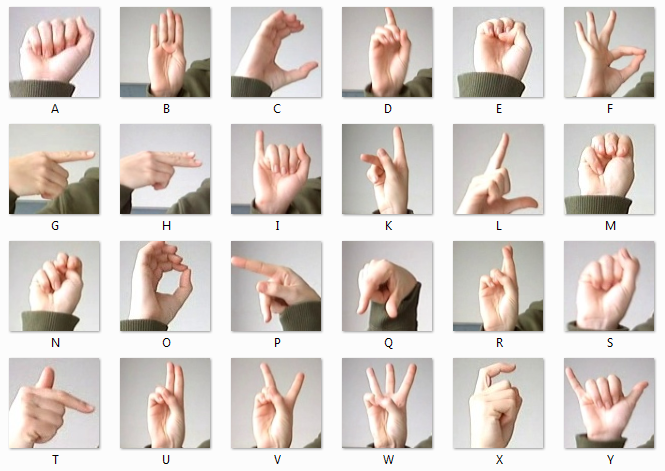

In [ ]:
img_sign =cv.imread('/content/amer_sign2.png')
cv2_imshow(img_sign)   ## Here is the image on which we are going to perform pre-processing techniques.

In [ ]:
data = pd.read_csv('/content/sign_mnist_train.csv')   ## reading csv file -> sign_mnist_train.csv

In [ ]:
data.head(10)      ## taking a glimpse of idea how are data looks

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179
5,16,161,168,172,173,178,184,189,193,196,...,76,74,68,62,53,55,48,238,255,255
6,8,134,134,135,135,136,137,137,138,138,...,109,102,91,65,138,189,179,181,181,179
7,22,114,42,74,99,104,109,117,127,142,...,214,218,220,223,223,225,227,227,228,228
8,3,169,174,176,180,183,185,187,188,190,...,119,118,123,120,118,114,94,74,61,57
9,3,189,189,189,190,190,191,190,190,190,...,13,53,200,204,201,201,193,175,178,156


In [ ]:

def create_input_directory(csv_file, input_dir):
    # Create the input directory if it doesn't exist
    os.makedirs(input_dir, exist_ok=True)

    # Read the CSV file and process each row
    with open(csv_file, 'r') as csvfile:
        csvreader = csv.reader(csvfile)
        next(csvreader)  # Skip the header row if it exists
        images = []
        labels = []
        for idx, row in enumerate(csvreader):
            # Extract the label and pixel data from the CSV row
            label = int(row[0])  # Assuming the label is in the first column
            pixel_data = np.array(row[1:], dtype=np.uint8)

            # Reshape the pixel data into a 28x28 image
            image = pixel_data.reshape(28, 28)
            labels.append(label)
            images.append(image)

            # Save the image as a PNG file in the output directory
            image_filename = os.path.join(input_dir, f'image_{idx:04d}.png')
            image = Image.fromarray(image)
            image.save(image_filename)

    # Convert the list of images to a NumPy array
    images = np.array(images)
    labels = np.array(labels)

    print(f"Input directory created at: {input_dir}")
    return images,labels


csv_file_path = '/content/sign_mnist_train.csv'
input_directory = '/content/input_directory'
images,labels = create_input_directory(csv_file_path, input_directory)



Input directory created at: /content/input_directory


In [ ]:
print('Shape of training Images:',images.shape)
print('Length of unique Training Labels:',len(set(labels)))

Shape of training Images: (27455, 28, 28)
Length of unique Training Labels: 24


In [ ]:
images_gray = np.expand_dims(images, axis=3)  ## Expanding the dimensions of the training set as color channel for grayscale is 1

In [ ]:
print('Shape of training Images:',images_gray.shape)

Shape of training Images: (27455, 28, 28, 1)


encoding labels to its corresponding alphabet

In [ ]:
def encode_label_to_alphabet(label):
        return chr(ord('A') + label)


encoded_labels = [encode_label_to_alphabet(label) for label in labels]

In [ ]:
newLabel = np.array(encoded_labels)
print(np.unique(newLabel))
print(len(np.unique(newLabel)))
print("missing label 'J' and 'Z")

['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R' 'S'
 'T' 'U' 'V' 'W' 'X' 'Y']
24
missing label 'J' and 'Z


In [ ]:
print(np.unique(labels))
print(len(np.unique(labels)))

[ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
24


In [ ]:
# Normalizing pixel values
# images_gray = images_gray/255.0 /

df_images_gray = pd.DataFrame(images_gray.reshape(images_gray.shape[0], -1))
df_images_gray.head()

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,107,118,127,134,139,143,146,150,153,156,...,207,207,207,207,206,206,206,204,203,202
1,155,157,156,156,156,157,156,158,158,157,...,69,149,128,87,94,163,175,103,135,149
2,187,188,188,187,187,186,187,188,187,186,...,202,201,200,199,198,199,198,195,194,195
3,211,211,212,212,211,210,211,210,210,211,...,235,234,233,231,230,226,225,222,229,163
4,164,167,170,172,176,179,180,184,185,186,...,92,105,105,108,133,163,157,163,164,179


Splitting the data into train and validtion set


In [ ]:
X_train, X_valid,y_train, y_valid = train_test_split(images_gray,labels ,
                                   random_state=42,
                                   test_size=0.2,
                                   shuffle=True)

In [ ]:
len(X_train)

21964

In [ ]:
X_valid[0].shape

(28, 28, 1)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
X_valid_reshaped = X_valid.reshape(X_valid.shape[0], -1)

# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform the training data
X_train_scaled = scaler.fit_transform(X_train_reshaped)

# Transform the validation data
X_valid_scaled = scaler.transform(X_valid_reshaped)

# Reshape the scaled data back to the original shape
X_train = X_train_scaled.reshape(X_train.shape)
X_valid = X_valid_scaled.reshape(X_valid.shape)

Creating an output directory for Grayscale Image and encoded labels

In [ ]:

def create_directories(images_gray, labels, encoded_labels, output_dir):
    # Create the main output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Create subdirectories for each data type (images, labels, encoded_labels)
    image_dir = os.path.join(output_dir, 'images')
    label_dir = os.path.join(output_dir, 'labels')
    encoded_label_dir = os.path.join(output_dir, 'encoded_labels')

    os.makedirs(image_dir, exist_ok=True)
    os.makedirs(label_dir, exist_ok=True)
    os.makedirs(encoded_label_dir, exist_ok=True)

    for i in range(len(images_gray)):
        # Save the image
        image_filename = os.path.join(image_dir, f'image_{i:04d}.png')
        image_array = images_gray[i].squeeze()  # Remove single-channel dimension
        image = Image.fromarray(image_array.astype(np.uint8))
        image.save(image_filename)

        # Save the label (as text)
        label_filename = os.path.join(label_dir, f'label_{i:04d}.txt')
        with open(label_filename, 'w') as label_file:
            label_file.write(str(labels[i]))

        # Save the encoded_label (as text)
        encoded_label_filename = os.path.join(encoded_label_dir, f'encoded_label_{i:04d}.txt')
        with open(encoded_label_filename, 'w') as encoded_label_file:
            encoded_label_file.write(encoded_labels[i])


output_directory = 'output_directory'
create_directories(images_gray, labels, encoded_labels, output_directory)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Giving user the option to augment the data

In [ ]:
def ask_for_augmentation():
    while True:
        try:
            user_input = input("Do you want to perform data augmentation? (True/False): ").strip().lower()
            if user_input in ["true", "false", "True", "False", "TRUE", "FALSE"]:
                return user_input in ["true", "True", "TRUE"]
            else:
                print("Invalid input. Please enter 'True' or 'False'.")
        except KeyboardInterrupt:
            print("\nUser interrupted. Exiting.")
            exit()


perform_augmentation = ask_for_augmentation()
if perform_augmentation:
    # Perform data augmentation
    print("Data augmentation is enabled.")
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range=0.1,  # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

    datagen.fit(X_train)
    datagen.fit(X_valid)
else:
    # Do not perform data augmentation
    print("Data augmentation is disabled.")


Do you want to perform data augmentation? (True/False): true
Data augmentation is enabled.


In [ ]:
print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape, X_train[0].shape)
from keras.models import Sequential
from tensorflow.keras import layers, regularizers, models
from keras.layers import Conv2D, Dense, BatchNormalization, MaxPool2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

(21964, 28, 28, 1) (5491, 28, 28, 1) (21964,) (5491,) (28, 28, 1)


In [ ]:
num_classes = len(np.unique(y_train))
print(num_classes)

24


In [ ]:
# Check for NaN or infinity values in your data
print(np.isnan(X_train).any())
print(np.isinf(X_train).any())
print(np.isnan(y_train).any())
print(np.isinf(y_train).any())

   # If found, replace them with appropriate values (e.g., mean, median)
X_train = np.nan_to_num(X_train)
y_train = np.nan_to_num(y_train)

False
False
False
False


In [ ]:
# model
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation="relu", input_shape=(28, 28, 1)),
    MaxPool2D(2, 2, padding='same'),
    Dropout(0.5),

    Conv2D(filters=128, kernel_size=(3, 3), activation="relu"),
    MaxPool2D(2, 2, padding='same'),
    Dropout(0.5),

    Conv2D(filters=512, kernel_size=(3, 3), activation="relu"),
    MaxPool2D(2, 2, padding='same'),
    Dropout(0.5),

    Flatten(),

    # Dense layers with L2 regularization
    Dense(units=4096, activation="relu", kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.5),

    Dense(units=1024, activation="relu", kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.5),

    Dense(units=256, activation="relu", kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.5),

    Dense(units=25, activation="softmax")
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 11, 11, 128)         │          36,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 4, 4, 512)           │         590,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 4096)                │       8,392,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1024)                │       4,195,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 25)                  │           6,425 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,484,505 (51.44 MB)

 Trainable params: 13,484,505 (51.44 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# compile the model

optimizer = tf.keras.optimizers.Adam(clipvalue=1.0)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
np.unique(y_train)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])

In [ ]:
checkpoint_filepath = 'best_model.keras'

callback_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath,
                                      save_weights_only=False,
                                      monitor='val_accuracy',
                                      mode='max',
                                      save_best_only=True)
callbacks = [callback_checkpoint]

In [ ]:
print(X_train.shape)

(21964, 28, 28, 1)


In [ ]:

history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid), callbacks=callbacks)

Epoch 1/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 66s 18ms/step - accuracy: 0.1390 - loss: 4.7861 - val_accuracy: 0.8248 - val_loss: 1.3299
Epoch 2/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.7201 - loss: 1.5500 - val_accuracy: 0.9439 - val_loss: 0.9111
Epoch 3/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.8617 - loss: 1.1289 - val_accuracy: 0.9940 - val_loss: 0.7482
Epoch 4/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9090 - loss: 0.9723 - val_accuracy: 0.9973 - val_loss: 0.6814
Epoch 5/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9337 - loss: 0.8655 - val_accuracy: 1.0000 - val_loss: 0.6088
Epoch 6/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9406 - loss: 0.8094 - val_accuracy: 0.9982 - val_loss: 0.5965
Epoch 7/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9506 - loss: 0.7574 - val_accuracy: 1.0000 - val_loss: 0.5817
Epoch 8/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.9523 - loss: 0.7369 - val_accura

In [ ]:
df1 = pd.read_csv('/content/sign_mnist_test.csv')
images1 = df1.drop(columns='label')
labels1 = df1['label'].values
new_shape = (7172, 28, 28)
images1 = images1.values.reshape(new_shape)

In [ ]:
df1.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,...,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,...,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,...,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,...,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,...,26,40,64,48,29,46,49,46,46,53


In [ ]:
X_test = images1
y_test = labels1

In [ ]:
num_samples = X_test.shape[0]
X_test_2D = X_test.reshape(num_samples, -1)
print(X_test_2D.shape)
scaler = StandardScaler()
X_test_scaled = scaler.fit_transform(X_test_2D)
X_test = X_test_scaled.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2],1)
print(X_test.shape)
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

(7172, 784)
(7172, 28, 28, 1)
225/225 - 2s - 10ms/step - accuracy: 0.9851 - loss: 0.5340


In [ ]:
model.save("my_model.keras")

In [ ]:
import cv2

In [ ]:
def encode_label_to_alphabet(label):
  alphabet = "ABCDEFGHIKLMNOPQRSTUVWXY"
  return alphabet[label]

In [ ]:
gray_scale_image = cv.imread('/content/e.webp', cv.IMREAD_GRAYSCALE)
print("gray shape:", gray_scale_image.shape)
resized_gray_image = cv.resize(gray_scale_image, (28, 28))
flat_img = resized_gray_image.flatten()
flat_img = flat_img.reshape(28, 28, 1)  # Remove the extra dimension
input_data = np.expand_dims(flat_img, axis=0)  # Add batch dimension

gray shape: (280, 287)


In [ ]:
result = np.argmax(model.predict(input_data).round(1))
print(model.predict(input_data).round(1))
print(encode_label_to_alphabet(result))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]]
E


In [ ]:
model.predict(np.expand_dims(X_test[0], axis = 0)).round(2)